In [1]:
from mne_bids import make_bids_basename
from pathlib import Path, PurePath
import seaborn
import helper
import mne
import os
import matplotlib.pyplot as plt
import pandas as pd
import matlab.engine
import numpy as np
import scipy as sp
import scipy.io
import re
pd.options.display.html.table_schema = True
pd.options.display.max_rows = None
from mne.time_frequency import psd_multitaper
%matplotlib 


Using matplotlib backend: Qt5Agg


In [12]:
proc = 'BP'
subid = 'DiAs'
cfsubdir = Path('~','CIFAR_data','iEEG_10','subjects', subid, 'EEGLAB_datasets', 'bipolar_montage').expanduser()
bids_subpath = Path('~','projects','CIFAR','data_bids', 'sub-04' ).expanduser()
elecinfo = bids_subpath.joinpath('anat','electrodes_info.csv')
dfelec = pd.read_csv(elecinfo)
ROIs = dfelec['Brodman'].unique()
nROIs = len(ROIs)
fname = helper.CIFAR_filename(subid=subid,task='rest_baseline',proc=proc)
fpath = cfsubdir.joinpath(fname)
fpath = os.fspath(fpath)
raw_DiAs = mne.io.read_raw_eeglab(fpath, preload=True)

Reading /home/guime/CIFAR_data/iEEG_10/subjects/DiAs/EEGLAB_datasets/bipolar_montage/DiAs_freerecall_rest_baseline_1_preprocessed_BP_montage.fdt
Reading 0 ... 104998  =      0.000 ...   209.996 secs...


<ipython-input-12-685788b9001e>:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_DiAs = mne.io.read_raw_eeglab(fpath, preload=True)
<ipython-input-12-685788b9001e>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_DiAs = mne.io.read_raw_eeglab(fpath, preload=True)


In [15]:
proc = 'BP'
subid = 'JuRo'
cfsubdir = Path('~','CIFAR_data','iEEG_10','subjects', subid, 'EEGLAB_datasets', 'bipolar_montage').expanduser()
bids_subpath = Path('~','projects','CIFAR','data_bids', 'sub-04' ).expanduser()
elecinfo = bids_subpath.joinpath('anat','electrodes_info.csv')
dfelec = pd.read_csv(elecinfo)
ROIs = dfelec['Brodman'].unique()
nROIs = len(ROIs)
fname = helper.CIFAR_filename(subid=subid,task='rest_baseline',proc=proc)
fpath = cfsubdir.joinpath(fname)
fpath = os.fspath(fpath)
raw_JuRo = mne.io.read_raw_eeglab(fpath, preload=True)

Reading /home/guime/CIFAR_data/iEEG_10/subjects/JuRo/EEGLAB_datasets/bipolar_montage/JuRo_freerecall_rest_baseline_1_preprocessed_BP_montage.fdt
Reading 0 ... 104998  =      0.000 ...   209.996 secs...


<ipython-input-15-499db3f967fd>:12: RuntimeWarning: Limited 1 annotation(s) that were expanding outside the data range.
  raw_JuRo = mne.io.read_raw_eeglab(fpath, preload=True)
<ipython-input-15-499db3f967fd>:12: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw_JuRo = mne.io.read_raw_eeglab(fpath, preload=True)


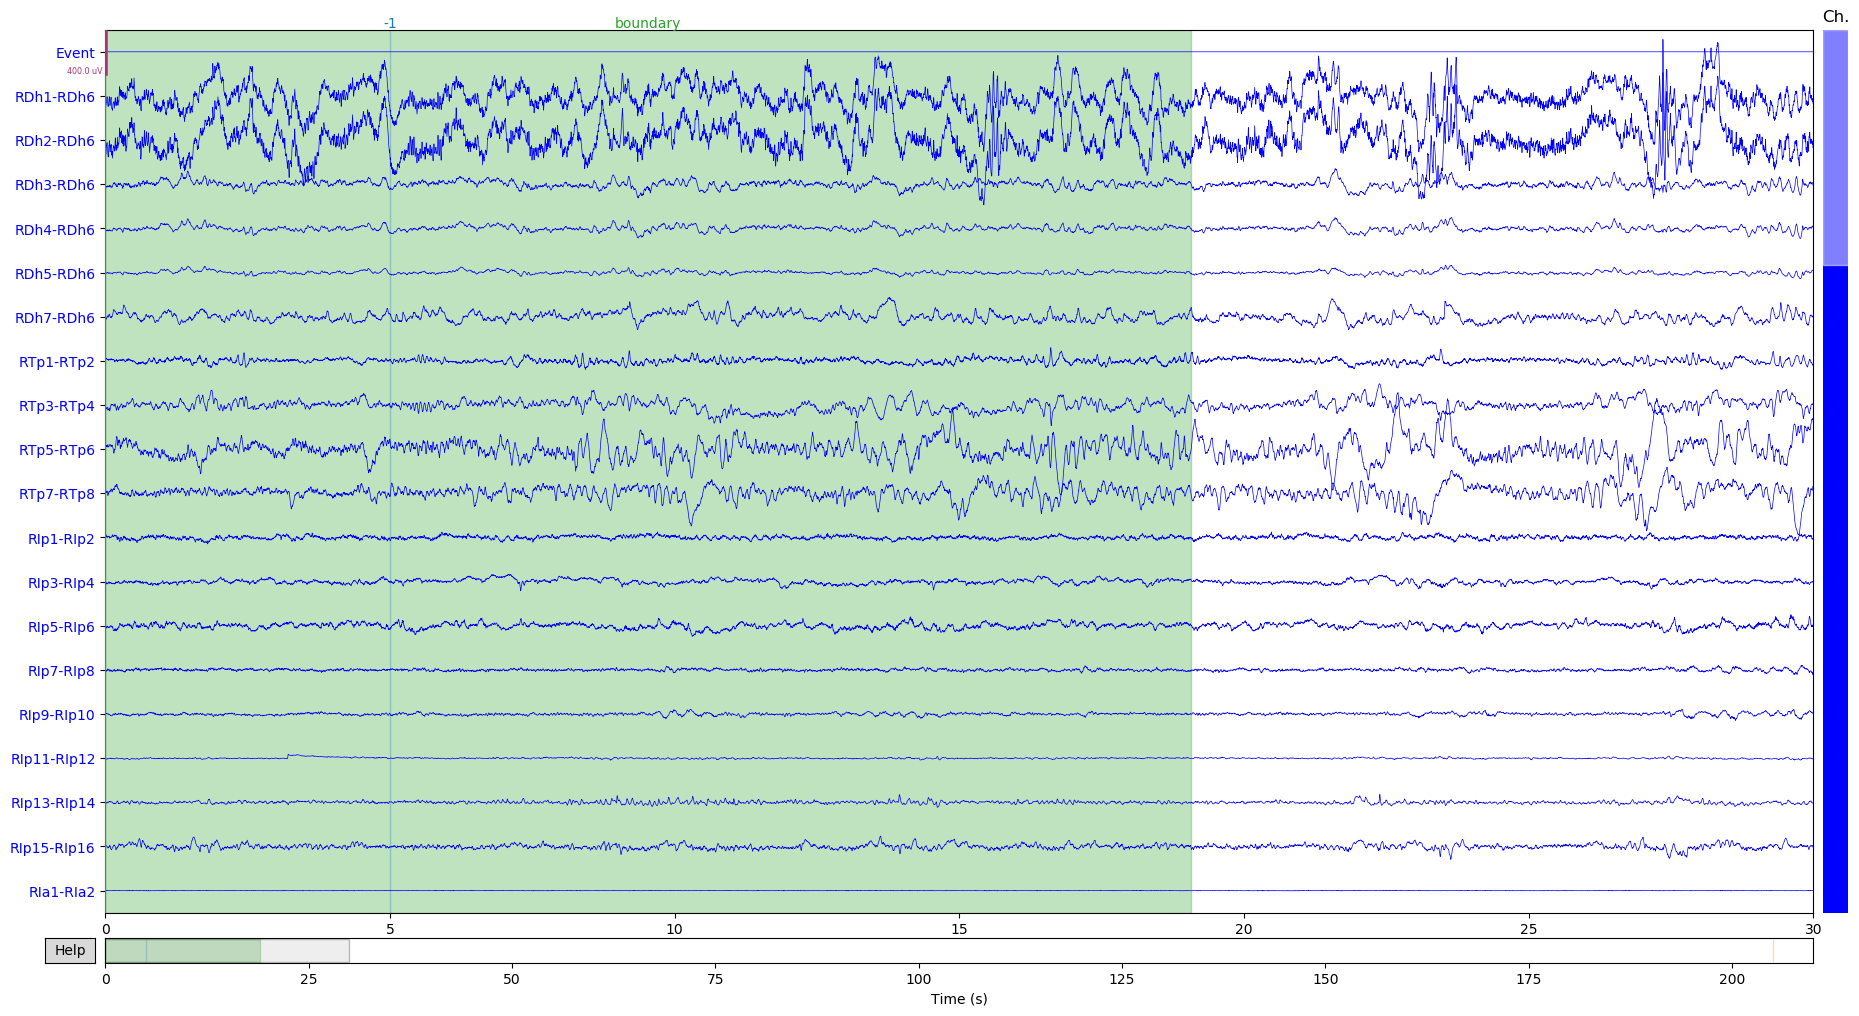

In [17]:
#raw_JuRo.plot(duration=30, n_channels=20, scalings=2e-4, color='b', butterfly=False)

In [18]:
chan_JuRo = ['RTo1-RTo2']
chan_DiAs = ['LTo1-LTo2']

In [38]:
events_JuRo =mne.make_fixed_length_events(raw_JuRo, duration=10)
events_DiAs =mne.make_fixed_length_events(raw_DiAs, duration=10)
epochs_JuRo = mne.Epochs(raw_JuRo, events_JuRo, picks=chan_JuRo ,tmin=-0.2, tmax=5)
epochs_DiAs = mne.Epochs(raw_DiAs, events_DiAs, picks=chan_DiAs, tmin=-0.2, tmax=5)

20 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated
20 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
0 projection items activated


In [39]:
evoked_JuRo = epochs_JuRo.average()
evoked_DiAs = epochs_DiAs.average()

In [56]:
X = evoked_JuRo.data
Y = evoked_DiAs.data
X = np.squeeze(X)
Y = np.squeeze(Y)

In [67]:
data = np.stack((X,Y))
data.shape

(2, 2601)

In [75]:
from statsmodels.tsa.api import acf, pacf, graphics
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.api import VAR

In [57]:
acf(X)

/home/guime/anaconda3/envs/neuro/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


array([ 1.        ,  0.99039259,  0.96542151,  0.92867238,  0.88174077,
        0.82664884,  0.76503239,  0.69846817,  0.62843277,  0.55640628,
        0.48364031,  0.41088874,  0.33883641,  0.26818584,  0.19953548,
        0.13320485,  0.06955831,  0.00920756, -0.04745294, -0.10053809,
       -0.15034521, -0.19699122, -0.24047091, -0.28088952, -0.31831284,
       -0.35248935, -0.38312312, -0.41014704, -0.4334324 , -0.45289265,
       -0.46875288, -0.48112811, -0.48996967, -0.49506298, -0.49611539,
       -0.49316916, -0.48645768, -0.47613064, -0.46208504, -0.44409804,
       -0.42197175])

In [61]:
fig = sm.graphics.tsa.plot_pacf(X, lags=40)

/home/guime/anaconda3/envs/neuro/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


In [76]:
data = np.transpose(data)

In [77]:
model = VAR(data)

In [91]:
results = model.fit(10)

In [88]:
results.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 21, May, 2020
Time:                     21:52:36
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -53.7646
Nobs:                     2597.00    HQIC:                  -53.7905
Log likelihood:           62514.1    FPE:                4.29246e-24
AIC:                     -53.8052    Det(Omega_mle):     4.26286e-24
--------------------------------------------------------------------
Results for equation y1
           coefficient       std. error           t-stat            prob
------------------------------------------------------------------------
const         0.000000         0.000000            0.519           0.603
L1.y1         1.978358         0.018733          105.607           0.000
L1.y2         0.008024         0.008527            0.941           0.347
L2.y1        -1.418696

In [81]:
#results.plot_acorr()

In [92]:
GC = results.test_causality(causing=0,caused=1)

In [93]:
GC.summary()

Test statistic,Critical value,p-value,df
1.071,1.833,0.381,"(10, 5140)"
